# CSE352 Homework 4
**Due date: 23:59 on May 3, 2021**

In this homework, we will use Google Colab, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Hardware accelerator -> GPU***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for object recognition ([cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html)) using [PyTorch](http://pytorch.org). 

In Problem 1, you will use the pre-trained features from a given CNN backbone network, and train a simple neural network consisting of a couple of feedforward layers and a classification layer. You will need to implement the loss function.

In Problem 2, you will implement your own CNN model, initialize model weights randomly and train from scratch.

In Problem 3, you will modify the given pre-trained CNN model and fine-tune model weights with the training data.

There are 3 problems in this homework with a total of 100 points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

**This assignment requries GPU. Make sure you choose GPU accelerator in Colab setting.**

**You are highly suggested to read this tutorial https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html before doing this homework.**

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation). By default, Colab has installed PyTorch.
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.
- Stanford cs231n class at https://cs231n.github.io/.

## A Few Terminologies
---
If you are unfamilar with deep learing terminologies, here is a brief tutorial https://www.analyticsvidhya.com/blog/2017/05/25-must-know-terms-concepts-for-beginners-in-deep-learning/

Some important concepts include:

Cost Function, Learning Rate, Batches, Epochs, Batch Normalization, Filters, CNN, Pooling




In [1]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Set your working directory (in your google drive)
#   change it to your specific homework directory.
import os
os.chdir("/content/gdrive/My Drive/Lee_Cynthia_111737790_A4")

In [4]:
ls

cifar100_net.pth  Lee_Cynthia111737790_A4.ipynb  Lee_Cynthia_111737790_A4.pdf


## Problem 0: Get Pre-trained CNN model from Cifar-100
---
This part is hidden. Students **DO NOT** need to do anything here.
---
The model is pre-trained with Cifar-100 for 100 class classification.

Model file is provided. 

Adapted from https://zhenye-na.github.io/2018/10/07/pytorch-resnet-cifar100.html

In [ ]:
# Normalize training set together with augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

# Normalize test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
            download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
            shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
            download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
            shuffle=False, num_workers=2)

NameError: ignored

In [ ]:
def conv3x3(in_channels, out_channels, stride=1):
    """3x3 kernel size with padding convolutional layer in ResNet BasicBlock."""
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False)


class BasicBlock(nn.Module):
    """Basic Block of ReseNet."""

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """Basic Block of ReseNet Builder."""
        super(BasicBlock, self).__init__()

        # First conv3x3 layer
        self.conv1 = conv3x3(in_channels, out_channels, stride)

        #  Batch Normalization
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)

        # ReLU Activation Function
        self.relu = nn.ReLU(inplace=True)

        # Second conv3x3 layer
        self.conv2 = conv3x3(out_channels, out_channels)

        #  Batch Normalization
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        # downsample for `residual`
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        """Forward Pass of Basic Block."""
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        return out

In [ ]:
class ResNet(nn.Module):
    """Residual Neural Network."""

    def __init__(self, num_classes=100):
        block = BasicBlock
        duplicates = [2,4,4,2]

        """Residual Neural Network Builder."""
        super(ResNet, self).__init__()

        self.in_channels = 32
        self.conv1 = conv3x3(in_channels=3, out_channels=32)
        self.bn = nn.BatchNorm2d(num_features=32)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=0.02)

        # block of Basic Blocks
        self.conv2_x = self._make_block(block, duplicates[0], out_channels=32)
        self.conv3_x = self._make_block(block, duplicates[1], out_channels=64, stride=2)
        self.conv4_x = self._make_block(block, duplicates[2], out_channels=128, stride=2)
        self.conv5_x = self._make_block(block, duplicates[3], out_channels=256, stride=2)

        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=1)
        self.fc_layer = nn.Linear(256, num_classes)

        # initialize weights
        # self.apply(initialize_weights)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _make_block(self, block, duplicates, out_channels, stride=1):
        """
        Create Block in ResNet.

        Args:
            block: BasicBlock
            duplicates: number of BasicBlock
            out_channels: out channels of the block

        Returns:
            nn.Sequential(*layers)
        """
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(num_features=out_channels)
            )

        layers = []
        layers.append(
            block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, duplicates):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)


    def pretrained_feature(self, x):
        """Forward pass of ResNet."""
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)

        # Stacked Basic Blocks
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)

        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        return out.detach()
    
    def forward(self, x):
        """Forward pass of ResNet."""
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)

        # Stacked Basic Blocks
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)

        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)

        return out

pretrainNet = ResNet().cuda()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class PreTrainNet(nn.Module):
    def __init__(self):
        super(PreTrainNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 8, 3)
        self.conv3 = nn.Conv2d(8, 16, 3)
        self.conv4 = nn.Conv2d(16, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 100)

    def feature(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def pretrained_feature(self, x):
        return x.detach()

    def forward(self, x):
        x = self.feature(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


pretrainNet = PreTrainNet().cuda()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrainNet.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-5)

In [ ]:
def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = pretrainNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 0.357
[1,   100] loss: 0.358
[1,   150] loss: 0.353
[2,    50] loss: 0.350
[2,   100] loss: 0.345
[2,   150] loss: 0.358
[3,    50] loss: 0.352
[3,   100] loss: 0.362
[3,   150] loss: 0.346
[4,    50] loss: 0.346
[4,   100] loss: 0.348
[4,   150] loss: 0.369
[5,    50] loss: 0.339
[5,   100] loss: 0.368
[5,   150] loss: 0.354
[6,    50] loss: 0.352
[6,   100] loss: 0.358
[6,   150] loss: 0.351
[7,    50] loss: 0.345
[7,   100] loss: 0.354
[7,   150] loss: 0.353
[8,    50] loss: 0.348
[8,   100] loss: 0.345
[8,   150] loss: 0.351
[9,    50] loss: 0.343
[9,   100] loss: 0.346
[9,   150] loss: 0.341
[10,    50] loss: 0.345
[10,   100] loss: 0.343
[10,   150] loss: 0.346
[11,    50] loss: 0.344
[11,   100] loss: 0.347
[11,   150] loss: 0.342
[12,    50] loss: 0.355
[12,   100] loss: 0.347
[12,   150] loss: 0.328
[13,    50] loss: 0.356
[13,   100] loss: 0.353
[13,   150] loss: 0.340
[14,    50] loss: 0.348
[14,   100] loss: 0.344
[14,   150] loss: 0.346
[15,    50] loss: 0

In [ ]:

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = pretrainNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


In [ ]:
# PATH = './cifar100_net.pth'
# torch.save(pretrainNet.state_dict(), PATH)

## Problem 1: Training with Pre-trained Features (40 points)
---
You will load a pretrained model and get pretrained features of the training images with this mode. Then you need to create your simple Neural Network, implement loss function, train and evaluate on Cifar-10. 

**In order to get full credits, your test accuracy should be higher than acc_ta-5%, where acc_ta is TA's implementation, shown in the block's output.**

You should keep training logs as they are in the block's output.

Load pretrained CNN model.

In [5]:
## This following two blocks define the pretrained CNN network architecture

def conv3x3(in_channels, out_channels, stride=1):
    """3x3 kernel size with padding convolutional layer in ResNet BasicBlock."""
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False)


class BasicBlock(nn.Module):
    """Basic Block of ReseNet."""

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """Basic Block of ReseNet Builder."""
        super(BasicBlock, self).__init__()

        # First conv3x3 layer
        self.conv1 = conv3x3(in_channels, out_channels, stride)

        #  Batch Normalization
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)

        # ReLU Activation Function
        self.relu = nn.ReLU(inplace=True)

        # Second conv3x3 layer
        self.conv2 = conv3x3(out_channels, out_channels)

        #  Batch Normalization
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        # downsample for `residual`
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        """Forward Pass of Basic Block."""
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        return out

In [6]:
class ResNet(nn.Module):
    """Residual Neural Network."""

    def __init__(self, num_classes=100):
        block = BasicBlock
        duplicates = [2,4,4,2]

        """Residual Neural Network Builder."""
        super(ResNet, self).__init__()

        self.in_channels = 32
        self.conv1 = conv3x3(in_channels=3, out_channels=32)
        self.bn = nn.BatchNorm2d(num_features=32)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=0.02)

        # block of Basic Blocks
        self.conv2_x = self._make_block(block, duplicates[0], out_channels=32)
        self.conv3_x = self._make_block(block, duplicates[1], out_channels=64, stride=2)
        self.conv4_x = self._make_block(block, duplicates[2], out_channels=128, stride=2)
        self.conv5_x = self._make_block(block, duplicates[3], out_channels=256, stride=2)

        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=1)
        self.fc_layer = nn.Linear(256, num_classes)

        # initialize weights
        # self.apply(initialize_weights)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _make_block(self, block, duplicates, out_channels, stride=1):
        """
        Create Block in ResNet.

        Args:
            block: BasicBlock
            duplicates: number of BasicBlock
            out_channels: out channels of the block

        Returns:
            nn.Sequential(*layers)
        """
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(num_features=out_channels)
            )

        layers = []
        layers.append(
            block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, duplicates):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)


    def pretrained_feature(self, x):
        """Forward pass of ResNet."""
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)

        # Stacked Basic Blocks
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)

        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        return out.detach()
    
    def forward(self, x):
        """Forward pass of ResNet."""
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)

        # Stacked Basic Blocks
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)

        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)

        return out

pretrainNet = ResNet().cuda()

# make sure upload model file to current directory             
pretrainNet.load_state_dict(torch.load('./cifar100_net.pth'))

<All keys matched successfully>

Load and show Cifar-10 sample images

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
          download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
          download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


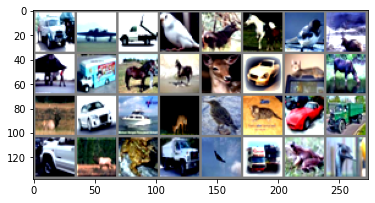

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:32]))



First, create your simple Neural Network consisting of a couple of feedforward layers (e.g. torch.nn.Linear) (**no convolutional layers required**). This model will take pretrained features as inputs. (20 points)

In [17]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleNet(nn.Module):
    def __init__(self):
        ##-------------TODO----------------#
        super(SimpleNet, self).__init__()

        # Linear(in_features, out_features) = layer
        # ReLU = activation function

        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(256, 1024),
            nn.ReLU(), 
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )
        ##-------------/TODO----------------#

    def forward(self, x): 
        ##-------------TODO----------------#  
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
        ##-------------/TODO----------------#

simpleNet = SimpleNet().cuda()

Then, implement the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) by yourself. You are not permitted to use torch.nn.CrossEntropyLoss directly, but you can use other non-loss pytorch methods like torch.nn.LogSoftmax, etc. (20 points)

For more information about loss functions, refer to https://cs231n.github.io/neural-networks-2/#losses . Basically, loss functions measures the compatibility between a prediction and the ground truth label. Cross entropy loss is the most widely used loss function for classification tasks. Here are some materials on cross entropy loss:

https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e

https://medium.com/data-science-bootcamp/understand-cross-entropy-loss-in-minutes-9fb263caee9a

https://datascience.stackexchange.com/questions/20296/cross-entropy-loss-explanation

In [18]:
import torch.optim as optim

class myCrossEntropyLoss(nn.Module):
    def __init__(self):
        ##-------------TODO----------------# 
        super(myCrossEntropyLoss, self).__init__()
        
        ##-------------/TODO----------------# 
    
    def forward(self, outputs, labels):
        ##-------------TODO----------------# 
        # ti = truth label
        # pi = Softmax probability for ith class
        # Lce = −∑ ti log(pi) for n classes
        
        def log_softmax(x):
            return x - x.exp().sum(-1).log().unsqueeze(-1)

        def nll(input, target):
            return -input[range(target.shape[0]), target].mean()

        # cross entropy loss = LogSoftmax + NLLLoss
        pred = log_softmax(outputs)
        loss = nll(pred, labels)
        return loss
        ##-------------/TODO----------------# 

# define loss function
criterion = myCrossEntropyLoss()

# define optimizer. Pay attention to the arguments
optimizer = optim.Adam(simpleNet.parameters(), lr=0.0005) # lr=0.0005

Train the model on training images.

In [19]:
def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # get pretrained features
        inputs = pretrainNet.pretrained_feature(inputs)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = simpleNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 1.562
[1,   100] loss: 1.134
[1,   150] loss: 1.043
[2,    50] loss: 0.974
[2,   100] loss: 0.977
[2,   150] loss: 0.988
[3,    50] loss: 0.927
[3,   100] loss: 0.921
[3,   150] loss: 0.929
[4,    50] loss: 0.878
[4,   100] loss: 0.885
[4,   150] loss: 0.884
[5,    50] loss: 0.856
[5,   100] loss: 0.840
[5,   150] loss: 0.861
[6,    50] loss: 0.810
[6,   100] loss: 0.804
[6,   150] loss: 0.830
[7,    50] loss: 0.781
[7,   100] loss: 0.802
[7,   150] loss: 0.794
[8,    50] loss: 0.757
[8,   100] loss: 0.754
[8,   150] loss: 0.754
[9,    50] loss: 0.748
[9,   100] loss: 0.722
[9,   150] loss: 0.756
[10,    50] loss: 0.691
[10,   100] loss: 0.714
[10,   150] loss: 0.703
[11,    50] loss: 0.679
[11,   100] loss: 0.672
[11,   150] loss: 0.676
[12,    50] loss: 0.653
[12,   100] loss: 0.639
[12,   150] loss: 0.665
[13,    50] loss: 0.633
[13,   100] loss: 0.617
[13,   150] loss: 0.628
[14,    50] loss: 0.588
[14,   100] loss: 0.609
[14,   150] loss: 0.600
[15,    50] loss: 0

Now, evaluate on the test images.

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        images = pretrainNet.pretrained_feature(images)
        outputs = simpleNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 68 %


## Problem 2: Training from scratch (30 points)
---
Now create your CNN model from scratch. This model will take raw images as input. You can refer to some representative CNN model architecture like [AlexNet](https://pytorch.org/hub/pytorch_vision_alexnet/), [VGGNet](https://pytorch.org/hub/pytorch_vision_vgg/), etc. You are **Not** required to implement residual connections like [ResNet](https://pytorch.org/hub/pytorch_vision_resnet/). You are free to use layers like torch.nn.Conv2d, torch.nn.MaxPool2d, torch.nn.BatchNorm2d, torch.nn.Dropout, etc. 

You can use torch.nn.init to initialize the parameters. See https://pytorch.org/docs/stable/nn.html for api descriptions.

To make it simpler, we provided an examplar network. You could improve from this. We did not initialize weights explictly, but you are **requried** to do that.

**In order to get full credits, your test accuracy should be higher than acc_ta, where acc_ta is TA's implementation, shown in the block's output.**

You should keep training logs as they are in the block's output.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class ExamplarNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Net(nn.Module):
    ##-------------TODO----------------# 
    def __init__(self):
        # build your network and initialize your weights by torch.nn.init
        # refer to https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
        
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self._initialize_weights()

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    ##-------------/TODO----------------# 

net = Net().cuda()

In [10]:
import torch.optim as optim

# define loss and optimizer
# refer to the previous problem. Make sure you use correct input parameters, and modify them (e.g. lr) as you need.
##-------------TODO----------------# 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) # optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
##-------------/TODO----------------# 

In [11]:
def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 2.244
[1,   100] loss: 1.962
[1,   150] loss: 1.769
[2,    50] loss: 1.560
[2,   100] loss: 1.518
[2,   150] loss: 1.491
[3,    50] loss: 1.403
[3,   100] loss: 1.369
[3,   150] loss: 1.366
[4,    50] loss: 1.296
[4,   100] loss: 1.262
[4,   150] loss: 1.282
[5,    50] loss: 1.216
[5,   100] loss: 1.212
[5,   150] loss: 1.195
[6,    50] loss: 1.180
[6,   100] loss: 1.138
[6,   150] loss: 1.163
[7,    50] loss: 1.102
[7,   100] loss: 1.145
[7,   150] loss: 1.128
[8,    50] loss: 1.077
[8,   100] loss: 1.081
[8,   150] loss: 1.076
[9,    50] loss: 1.062
[9,   100] loss: 1.063
[9,   150] loss: 1.063
[10,    50] loss: 1.000
[10,   100] loss: 1.002
[10,   150] loss: 1.013
[11,    50] loss: 0.994
[11,   100] loss: 1.007
[11,   150] loss: 0.980
[12,    50] loss: 0.938
[12,   100] loss: 0.955
[12,   150] loss: 0.972
[13,    50] loss: 0.929
[13,   100] loss: 0.947
[13,   150] loss: 0.915
[14,    50] loss: 0.906
[14,   100] loss: 0.905
[14,   150] loss: 0.902
[15,    50] loss: 0

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


## Problem 3: Fine Tuning a Pre-Trained Deep Network (30 points)
Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks generalize surprisingly well to other recognition tasks. The pretrained model is obtained on Cifar-100 for 100 classes classification, and you will adapt it to Cifar-10 for 10 classes classification.

**In order to get full credits, your test accuracy should be higher than acc_ta-5%, where acc_ta is TA's implementation, shown in the block's output.**

You should keep training logs as they are in the block's output.      
       
**Hints**:
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [13]:
import torch.nn as nn
import torch.nn.functional as F


class FineTuneNet(nn.Module):
    # hint: initialize the pretrained network in __init__ and replace the extra layers
    def __init__(self):
        ##-------------TODO----------------# 
        super(FineTuneNet, self).__init__()

        pretrainNet = ResNet().cuda()
        pretrainNet.load_state_dict(torch.load('./cifar100_net.pth'))
        
        self.model_ft = pretrainNet
        self.num_ftrs = self.model_ft.fc_layer.in_features
        self.model_ft.fc_layer = nn.Linear(self.num_ftrs, 10)
        ##-------------/TODO----------------# 

    def forward(self, x):
        ##-------------TODO----------------# 
        return self.model_ft.forward(x)
        ##-------------/TODO----------------# 

fineTuneNet = FineTuneNet().cuda()

# load the pretrained networks from the pre-trained model cifar100_net.pth
# you can also do this in the __init__ above
# this follow blank is not compulsory 
##-------------TODO----------------# 

##-------------/TODO----------------# 

In [14]:
import torch.optim as optim

# define loss and optimizer
##-------------TODO----------------# 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fineTuneNet.parameters(), lr=0.001, momentum=0.9)
##-------------/TODO----------------# 

In [15]:
def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = fineTuneNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 1.717
[1,   100] loss: 0.981
[1,   150] loss: 0.858
[2,    50] loss: 0.713
[2,   100] loss: 0.681
[2,   150] loss: 0.678
[3,    50] loss: 0.612
[3,   100] loss: 0.581
[3,   150] loss: 0.575
[4,    50] loss: 0.529
[4,   100] loss: 0.531
[4,   150] loss: 0.531
[5,    50] loss: 0.483
[5,   100] loss: 0.486
[5,   150] loss: 0.487
[6,    50] loss: 0.449
[6,   100] loss: 0.448
[6,   150] loss: 0.461
[7,    50] loss: 0.417
[7,   100] loss: 0.434
[7,   150] loss: 0.411
[8,    50] loss: 0.401
[8,   100] loss: 0.397
[8,   150] loss: 0.386
[9,    50] loss: 0.378
[9,   100] loss: 0.366
[9,   150] loss: 0.367
[10,    50] loss: 0.342
[10,   100] loss: 0.346
[10,   150] loss: 0.351
[11,    50] loss: 0.329
[11,   100] loss: 0.323
[11,   150] loss: 0.329
[12,    50] loss: 0.297
[12,   100] loss: 0.315
[12,   150] loss: 0.319
[13,    50] loss: 0.291
[13,   100] loss: 0.286
[13,   150] loss: 0.292
[14,    50] loss: 0.270
[14,   100] loss: 0.274
[14,   150] loss: 0.268
[15,    50] loss: 0

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = fineTuneNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 85 %


## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw4' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_A*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_A*
        |---Surname_Givenname_SBUID_A*.ipynb
        |---Surname_Givenname_SBUID_A*.pdf
```

For instance, student Yann LeCun should submit a zip file named "LeCun_Yann_111134567_A4.zip" for homework4 in this structure:
```
LeCun_Yann_111134567_A4
        |---LeCun_Yann_111134567_A4.ipynb
        |---LeCun_Yann_111134567_A4.pdf
```

The **Surname_Givenname_SBUID_A*.pdf** should include a **google shared link**. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_A*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter two TA's emails: **tao.sun.1@stonybrook.edu*** and ***tianyi.zhao@stonybrook.edu@stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
Submissions between fourth and fifth day will be docked 20%. Submissions between fifth and sixth day will be docked 40%. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the penaly will be imposed if not using the grace period.

<!--Write your report here in markdown or html-->
